# Домашняя работа: "Методы оптимизации"

ФИО: Старжевский Тимофей Евгеньевич

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 9 октября.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

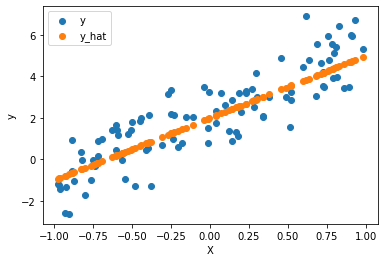

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

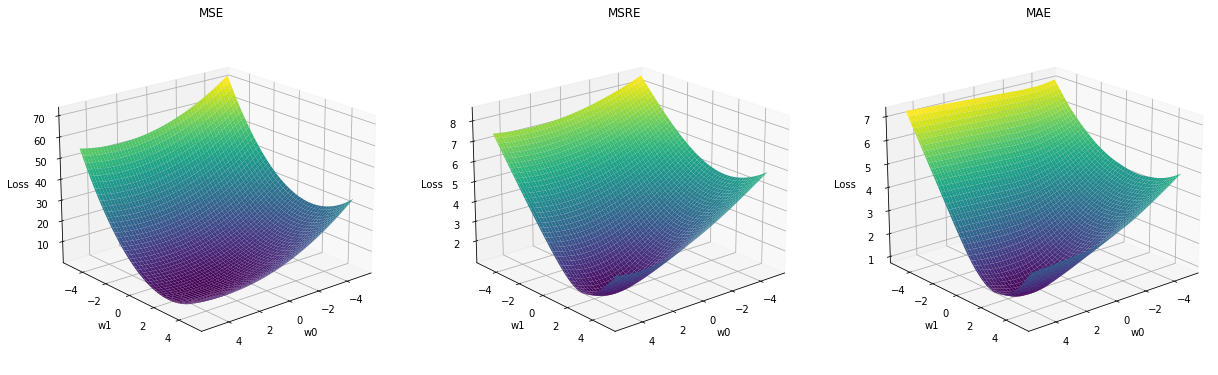

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD, NAG, AdaGrad, RMSProp с семинара:

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                prev_momentum = self.momentum[i]
                self.momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                p -= (1 + self.gamma) * self.momentum[i] - self.gamma * prev_momentum

In [10]:
class AdaGrad(Optimizer):
    def __init__(self, params, eta=1e-8, nu=1e-2):
        super().__init__(params)
        self.eta = eta
        self.nu = nu

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.nu / torch.sqrt(self.G[i] + self.eta) * p.grad

In [11]:
class RMSProp(Optimizer):
    def __init__(self, params, eta=1e-8, nu=1e-2, gamma=0.9):
        super().__init__(params)
        self.eta = eta
        self.nu = nu
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
         with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)
                p -= self.nu / torch.sqrt(self.G[i] + self.eta) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
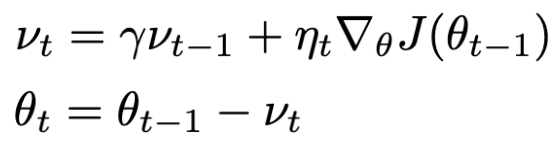

In [12]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.momentum[i] = self.gamma * self.momentum[i] + self.lr * p.grad
                p -= self.momentum[i]

#### AdaDelta
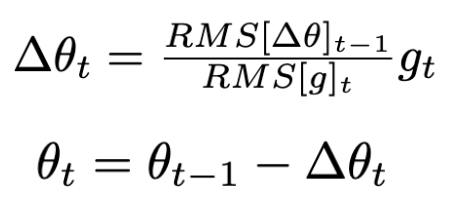

In [13]:
class AdaDelta(Optimizer):
    def __init__(self, params, eta=1e-8, gamma=0.9, initial=1e-8):
        super().__init__(params)
        self.eta = eta
        self.gamma = gamma

        self.squared_gradients = [torch.zeros_like(p) for p in self.params] # G
        self.squared_parameters = [torch.full_like(p, initial) for p in self.params] # P

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.squared_gradients[i] = self.gamma * self.squared_gradients[i] + (1 - self.gamma) * p.grad**2

                delta = torch.sqrt((self.squared_parameters[i] + self.eta) / (self.squared_gradients[i] + self.eta)) * p.grad

                p -= delta

                self.squared_parameters[i] = self.gamma * self.squared_parameters[i] + (1 - self.gamma) * delta**2


#### Adam
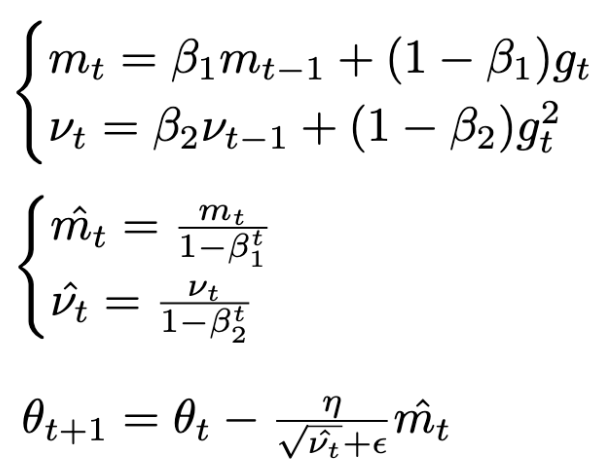

In [14]:
class Adam(Optimizer):
    def __init__(self, params, lr=0.001, b1=0.9, b2=0.999, eta=1e-8):
        super().__init__(params)
        self.lr = lr
        self.b1 = b1
        self.b2 = b2
        self.eta = eta

        self.momentums = [torch.zeros_like(p) for p in self.params]
        self.second_moments = [torch.zeros_like(p) for p in self.params]
        self.timestep = 0

    def step(self):
        self.timestep += 1

        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.momentums[i] = self.b1 * self.momentums[i] + (1 - self.b1) * p.grad
                self.second_moments[i] = self.b2 * self.second_moments[i] + (1 - self.b2) * p.grad**2

                corrected_moment = self.momentums[i] / (1 - self.b1**self.timestep)
                corrected_second_moment = self.second_moments[i] / (1 - self.b2**self.timestep)

                p -= (self.lr / (torch.sqrt(corrected_second_moment) + self.eta)) * corrected_moment
                

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [15]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [38]:
# sudo apt install ffmpeg
import matplotlib.animation as manimation; manimation.writers.list()


['pillow', 'html']

In [90]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1e-8, 'nu' : 1}],
        ['RMSProp', RMSProp, {'nu' : 1}],

        ['AdaDelta', AdaDelta, {'eta': 1e-8, 'gamma': 0.999, 'initial': 1e-2 }],
        ['Adam', Adam, {'lr': 0.2, 'b1': 0.9, 'b2': 0.999, 'eta': 1e-8}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


In [89]:
compare_optimizers(
    loss_animator,
    mse,
    [
        # ['SGD', SGD, {'lr': 1e-1}],
        # ['NAG', NAG, {'lr': 1e-1}],
        # ['Momentum', Momentum, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1e-8, 'nu' : 1}],
        ['RMSProp', RMSProp, {'nu' : 1}],

        ['AdaDelta', AdaDelta, {'eta': 1e-8, 'gamma': 0.999, 'initial': 1e-2 }],
        ['Adam', Adam, {'lr': 0.2, 'b1': 0.9, 'b2': 0.999, 'eta': 1e-8}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


## Выводы
1. Самые быстро попадающие в нужную точку - AdaDelta & RMSProp. AdaDelta добирается быстрее RMSProp, причем когда добралась до нужного значения, не "дрожит", то есть более стабильна
2. Adam идет очень малыми шагами, при этом не сразу попадает в локальный минимум, у него есть "инерция". Он медленнее снижает loss чем AdaGrad, но я предпочту Adam нежели AdaGrad в дальнейшем. AdaGrad не дает возможности появится новому минимуму, из-за затухания обновлений.
3. SGD & Momentum & NAG имеют наиболее точную SGD, но NAG доберется быстрее в нужную точку, Momentum будет иметь большие колебания и даже медленнее SGD. Из них я предпочту NAG

#### Как итог, в дальнейшем я скорее буду пользоваться вот в таком порядке:
- AdaDelta - самый быстрый результат локального минимума
- Adam - устойчивый поиск минимума
- NAG - Разбросанный поиск разных минимумов (менее устойчив чем Adam, но на мега неровной поверхности стоит проверить его)
- AdaGrad - по сути среднее между Adam & AdaDelta, но маловероятно, что изменит первый найденный локальный минимум.

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [16]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-10-02 20:46:39--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-10-02 20:46:40--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [       <=>          ]  33,20M   267KB/s    in 2m 24s  

2023-10-02 20:49:04 (236 KB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/

In [17]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.ac = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.ac(self.pool1(self.conv1(x)))
        x = self.ac(self.pool2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Тензор перед подачей в полносвязный слой
        x = self.dropout(x)
        x = self.ac(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x)

In [20]:
network = Net()
# optimizer = AdaDelta(params=network.parameters(), gamma=0.999, eta=1e-8, initial=1e-2) # Loss: 3.075286
optimizerAD = AdaDelta(params=network.parameters(), gamma=0.9, eta=1e-6, initial=0) # Loss: 0.007419

# optimizer = Adam(params=network.parameters(),lr=0.5, b1=0.9, b2=0.999, eta=1e-8) # Loss: 2.367716
optimizerAm = Adam(params=network.parameters(),lr=1e-3, b1=0.9, b2=0.999, eta=1e-8)

optimizerSGD = SGD(params=network.parameters(),lr=0.01) # Loss: 0.143527

# optimizer = AdaGrad(params=network.parameters(), nu=1, eta=1e-8) # Loss: 2.310202
optimizerAG = AdaGrad(params=network.parameters(), nu=1e-2, eta=1e-10)

Запустите обучение, постройте график лоссов от эпохи:

In [ ]:
optimizer = AdaDelta(params=network.parameters(), gamma=0.9, eta=1e-6, initial=0) # Loss: 0.007419
losses = []

network.train()
for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()


    if batch_idx % 100 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        1, batch_idx * len(data), len(train_loader.dataset),
         100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())

/tmp/ipykernel_10133/1290688351.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314307
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.527049
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.585467
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.498165
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.567929
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.349034
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.323446
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.172428
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.160724
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.122384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.367450
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.320036
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.232263
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.205895
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.144141
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.138108
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.091033
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.268165
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.143527


### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

In [19]:
from tqdm import tqdm

import numpy as np
import sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [21]:
def train(model, optimizer, n_epochs=5, plot=True, verbose=True, validate_each=2, loss_fn=None, 
          train_dataloader=train_loader, val_dataloader=test_loader):
    loss_fn = loss_fn or F.nll_loss
    test_loss_epochs = []
    test_accuracy_epochs = []

    for epoch in range(n_epochs):
        
        # обучение
        print(f'Train epoch {epoch}', end=' ')
        for x_train, y_train in tqdm(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optimizer.step()

        # валидация
        if epoch % validate_each == 0 or (epoch + 1) % n_epochs == 0:
            print('\nValidate', end=' ')
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = loss_fn(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            clear_output(True)
            test_loss_epochs.append(np.mean(val_loss))
            test_accuracy_epochs.append(np.mean(val_accuracy))
            if verbose:
                sys.stdout.write('\rEpoch {0} | Test validation Loss: {1:.3f}\tAccuracy: {2:.3f}'.format(
                            epoch, test_loss_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(test_loss_epochs, label='Loss')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(test_accuracy_epochs, label='Accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()

Epoch 4 | Test validation Loss: 0.038	Accuracy: 0.991

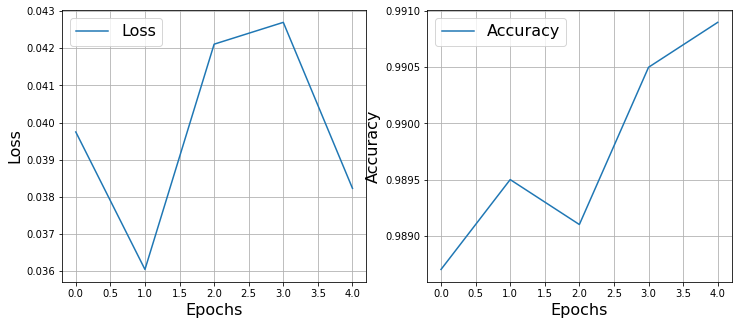

In [29]:
train(network, optimizerAD, validate_each=1)

Epoch 4 | Test validation Loss: 0.041	Accuracy: 0.988

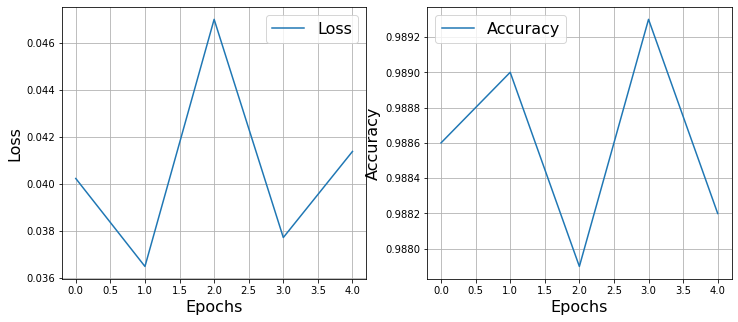

In [31]:
train(network, optimizerAm, validate_each=1)

Epoch 4 | Test validation Loss: 0.033	Accuracy: 0.992

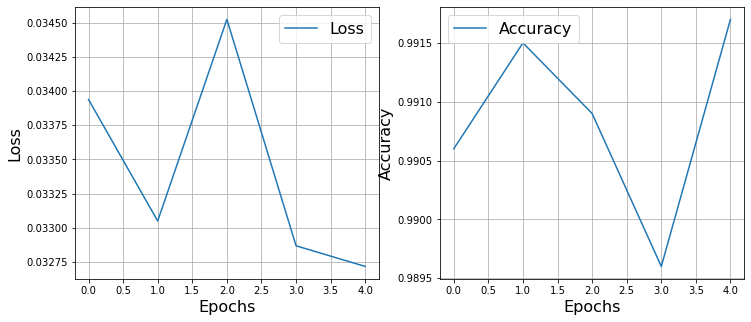

In [32]:
train(network, optimizerSGD, validate_each=1)

Epoch 4 | Test validation Loss: 0.030	Accuracy: 0.993

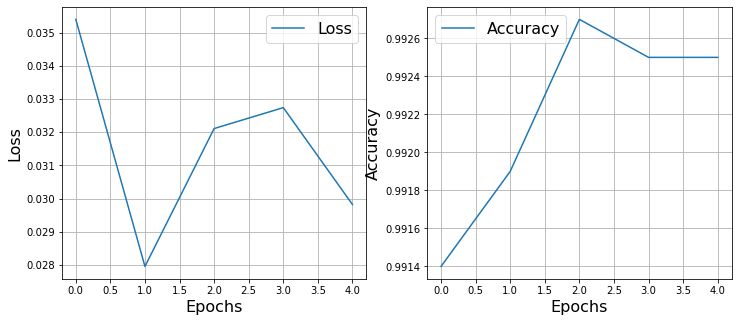

In [33]:
train(network, optimizerAG, validate_each=1)

## Анализ графиков
Результаты видны только на 5 эпохах, но они схожи с видео графиками
- AdaGrad дало лучший результат на этом числе, однако видно, что она замедлила улучшение результата
- AdaDelta при этом целенаправлено идет в выбранный минимум, но изменить она вряд ли его сможет из-за затухания
- SGD показала средний результат, при этом на текущих эпохах ее функция потерь выглядит более лучше на мой взгляд, хотя тут значения loss граничат с минимальными, и судить по ним не очень логично
- Adam показал результат хуже всего, но это связано с малым числом эпох. Она подготовила свои параметры к стабильной инерции, и я думаю дальше она пойдет стабильно улучшать результат

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Которую заметил я в чате:
- Опечатка в NAG оптимизаторе, где вместо 1 - self.gamma должен быть self.lr

В этом ноутбуке ее поправил

## Итоги

#### В дальнейшем я скорее буду пользоваться оптимизаторами вот в таком порядке:
- AdaDelta - самый быстрый результат локального минимума
- Adam - устойчивый поиск минимума
- NAG - Разбросанный поиск разных минимумов (менее устойчив чем Adam, но на мега неровной поверхности стоит проверить его)
- AdaGrad - по сути среднее между Adam & AdaDelta, но маловероятно, что изменит первый найденный локальный минимум.